In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, L1Loss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
n_connections = 3
input_dims = 8
hidden_dims = [8]
output_dims = 1
q_depth = 1
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

In [3]:
X = np.load(r'../../../data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'../../../data/qg_graph/y10_sorted_12500.npy')

In [4]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [5]:
X = X[:,:n_connections,:]
X_new = feature_engineer_dataset(X)

In [6]:
torch.amax(X_new,dim=(0,1))
X_norm = X_new / torch.amax(X_new, dim=(0,1))
X_norm.shape

torch.Size([12500, 3, 8])

In [7]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(M-1, n_connections-1)    # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [8]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long))
        dataset.append(data)
        
    return dataset

In [9]:
dataset = create_graph_dataset(X_norm,y)
len(dataset), dataset[0]

(12500, Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=0))

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph_samples(dataset, num_samples=3):
    plt.figure(figsize=(10, 5 * num_samples))
    
    for i, data in enumerate(dataset[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        
        # Convert the graph to a NetworkX format
        G = to_networkx(data, to_undirected=True)
        
        # Extract node features and visualize them as node labels
        node_labels = {j: f"pt: {data.x[j][0]:.2f}, y: {data.x[j][1]:.2f}, phi: {data.x[j][2]:.2f}, mt: {data.x[j][3]:.2f}" 
                       for j in range(data.x.size(0))}
        
        # Draw the graph with node labels
        nx.draw(G, with_labels=True, labels=node_labels, node_size=200, font_size=10)
        plt.title(f"Graph {i} (Label: {data.y.item()})")
    
    plt.show()

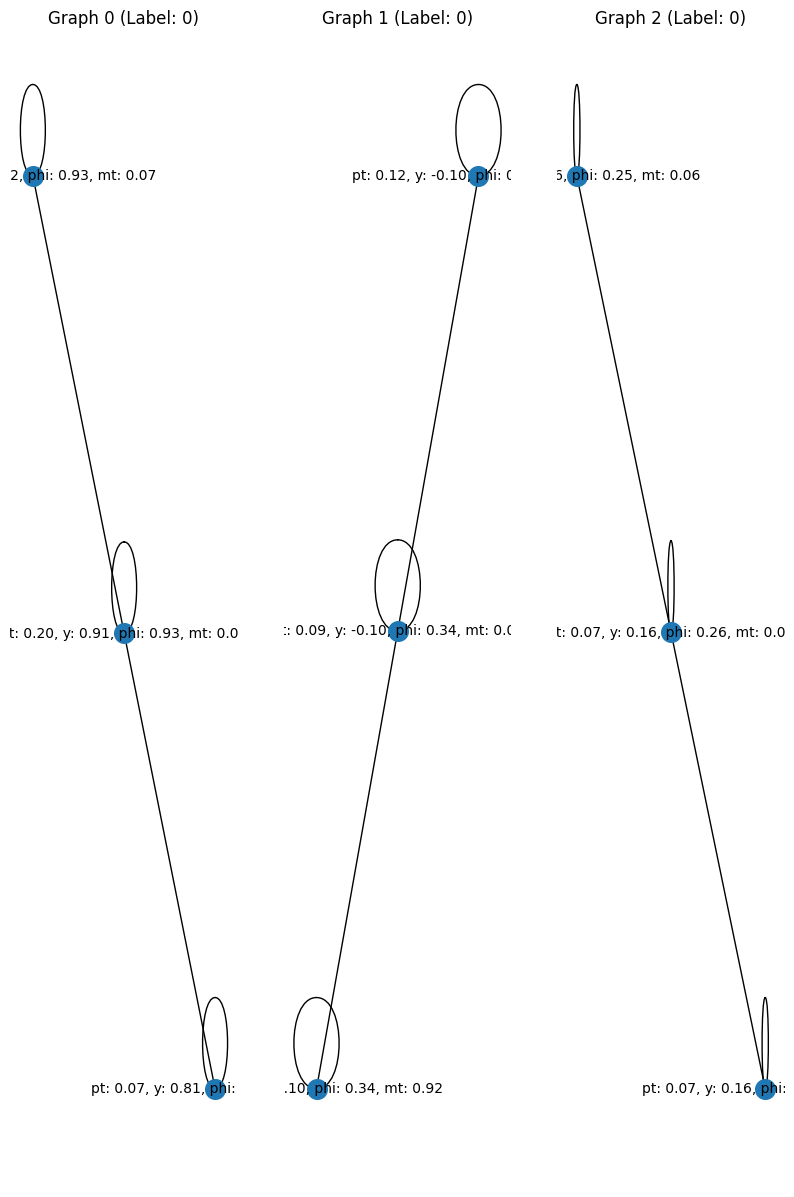

In [11]:
# Example usage:
visualize_graph_samples(dataset, num_samples=3)

In [12]:
import random
from torch_geometric.data import Data
from collections import defaultdict

def create_contrastive_pairs(dataset):
    pairs = []
    labels = []

    # Group graphs by their labels (0 or 1)
    label_to_graphs = defaultdict(list)
    for data in dataset:
        label_to_graphs[data.y.item()].append(data)

    # Convert labels to lists for faster access
    positive_class = label_to_graphs[1]
    negative_class = label_to_graphs[0]

    # Iterate through the dataset to create pairs
    for data1 in dataset:
        # Pick a random positive pair (same class)
        if data1.y.item() == 1:
            positive_pair = random.choice(positive_class)
        else:
            positive_pair = random.choice(negative_class)

        pairs.append((data1, positive_pair))
        labels.append(1)  # Label 1 for positive pair

        # Pick a random negative pair (different class)
        if data1.y.item() == 1:
            negative_pair = random.choice(negative_class)
        else:
            negative_pair = random.choice(positive_class)

        pairs.append((data1, negative_pair))
        labels.append(0)  # Label 0 for negative pair

    return pairs, labels


In [13]:
pairs, pair_labels = create_contrastive_pairs(dataset)


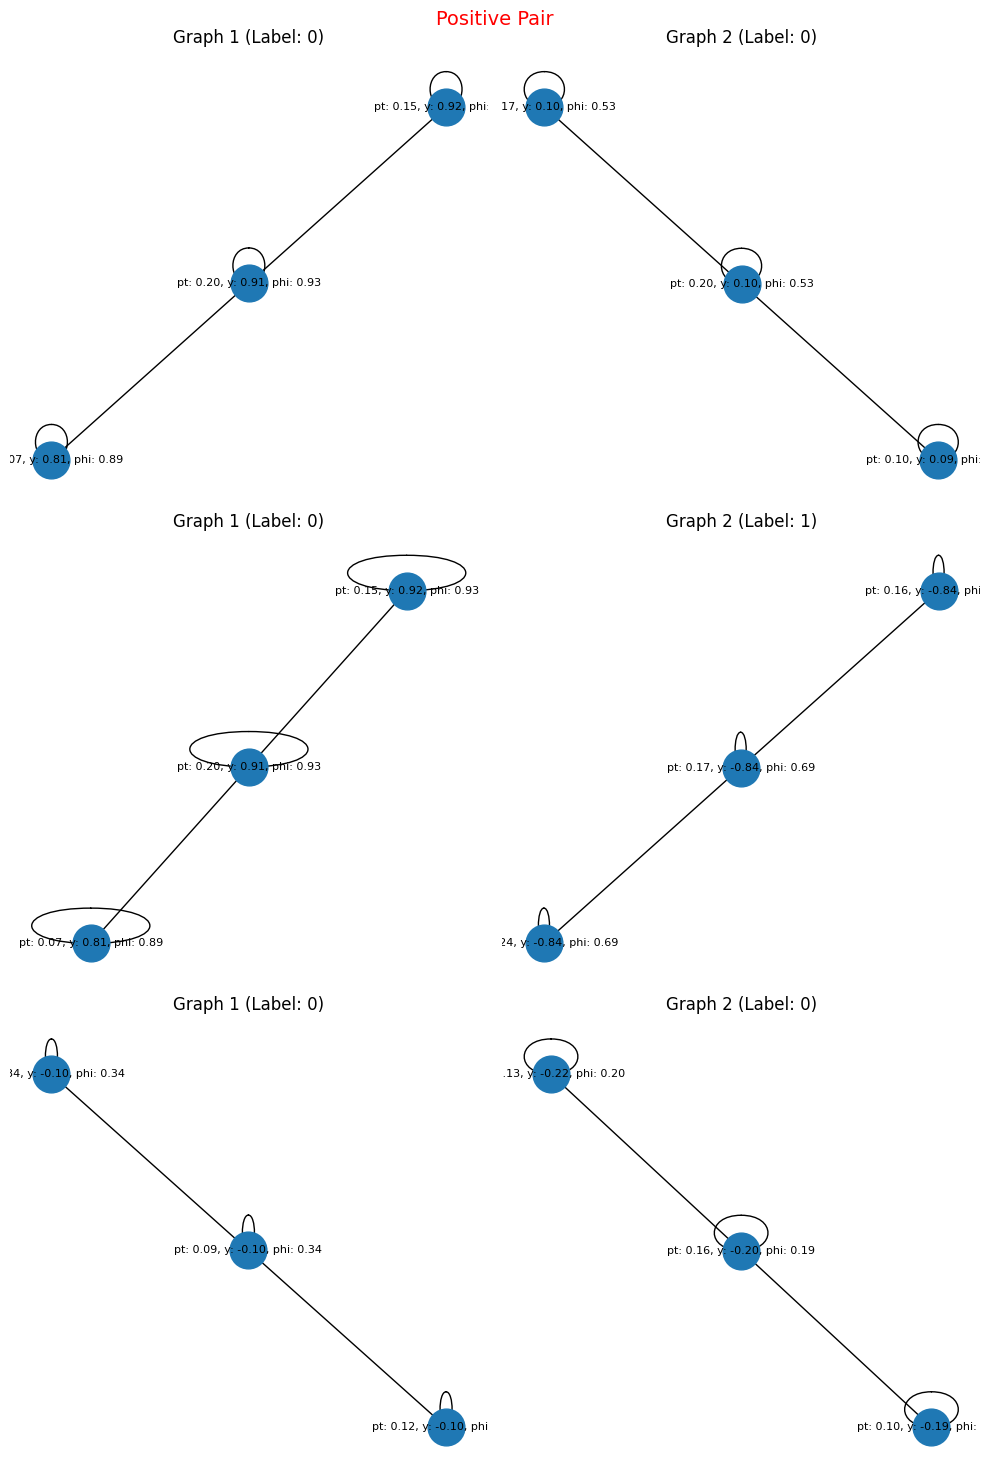

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph_pairs(pairs, labels, num_pairs=3):
    plt.figure(figsize=(10, 5 * num_pairs))
    
    for i, (data1, data2) in enumerate(pairs[:num_pairs]):
        # Create a subplot for each pair
        plt.subplot(num_pairs, 2, 2 * i + 1)
        
        # Convert both graphs to NetworkX format for visualization
        G1 = to_networkx(data1, to_undirected=True)
        node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 
                         for j in range(data1.x.size(0))}
        
        nx.draw(G1, with_labels=True, labels=node_labels_1, node_size=700, font_size=8)
        plt.title(f"Graph 1 (Label: {data1.y.item()})")

        plt.subplot(num_pairs, 2, 2 * i + 2)
        G2 = to_networkx(data2, to_undirected=True)
        node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 
                         for j in range(data2.x.size(0))}
        
        nx.draw(G2, with_labels=True, labels=node_labels_2, node_size=700, font_size=8)
        plt.title(f"Graph 2 (Label: {data2.y.item()})")

        pair_type = "Positive Pair" if labels[i] == 1 else "Negative Pair"
        plt.suptitle(pair_type, fontsize=14, color='red')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_graph_pairs(pairs, pair_labels, num_pairs=3)


In [15]:
from torch.utils.data import Dataset

class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  # List of (graph1, graph2) tuples
        self.labels = labels  # List of similarity labels (0 or 1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label


In [16]:
import torch
from sklearn.model_selection import train_test_split

def split_pairs(pairs, labels, train_ratio, val_ratio):
    # Split train and temporary (val + test)
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    
    # Split validation and test from the temporary set
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

# Assuming pairs and labels are created using create_contrastive_pairs()
pairs, labels = create_contrastive_pairs(dataset)  # Create pairs for the entire dataset

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the pairs into training, validation, and test sets
train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [17]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
train_dataset[0][0].x

tensor([[ 0.7303, -0.3312,  0.0064,  0.3341,  0.0000,  0.7298,  0.0318, -0.0883],
        [ 0.0667, -0.3241,  0.0059,  0.4790,  0.2099,  0.0666,  0.0027, -0.1235],
        [ 0.0648, -0.3516,  0.0083,  0.0297,  0.0000,  0.0648,  0.0037, -0.0084]])

In [19]:
train_dataset[0][1].x

tensor([[0.3199, 0.0420, 0.1290, 0.1985, 0.0491, 0.2134, 0.2500, 0.0062],
        [0.1334, 0.0334, 0.1299, 0.0610, 0.0000, 0.0884, 0.1048, 0.0015],
        [0.1279, 0.0308, 0.1298, 0.0585, 0.0000, 0.0848, 0.1004, 0.0013]])

In [20]:
train_dataset[0]

(Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=1),
 Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=1),
 1)

In [21]:


# Check a sample from the dataloader
for data1, data2, label in train_dataloader:
    print(data1)
    print(data2)
    print(label)
    break


DataBatch(x=[96, 8], edge_index=[2, 192], edge_attr=[192, 1], y=[32], batch=[96], ptr=[33])
DataBatch(x=[96, 8], edge_index=[2, 192], edge_attr=[192, 1], y=[32], batch=[96], ptr=[33])
tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1])


In [22]:
from torch_geometric.nn import GATConv, global_mean_pool, GraphConv
from torch.nn import ModuleList, Linear, ReLU
import torch


class GNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.readout_layer = Linear(hidden_dims[-1], output_dims)  # No final classifier, just embeddings
        self.dropout = torch.nn.Dropout(p=0.5)  # Add dropout to layers


    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
            h = self.dropout(h)  # Apply dropout
         
        h = global_mean_pool(h, batch)   # Readout layer to get the embedding for each graph in batch
        return h  # Return the graph embeddings


In [23]:
def run_model(model, epoch, dataloader, lossFn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x, data1.edge_index, data1.batch)
        emb2 = model(data2.x, data2.edge_index, data2.batch)
        
        # Compute contrastive loss
        loss = lossFn(emb1, emb2)  # Now the labels are passed explicitly
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            # correct = (predictions == labels.to(self.device)).sum().item()
            correct += (predictions == labels).sum().item()
            total = labels.size(0)
            # accuracy = correct / total
            # print(accuracy)
        # with torch.no_grad():
        #     distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1))  # L2 distance
        #     predictions = (distances < 0.5).float()  # Threshold of 0.5 for similarity
        #     correct += (predictions == labels).sum().item()

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples
    return avg_loss, accuracy


In [24]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Run training
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        
        # Run validation
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)
        
        # Print results
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Store loss and accuracy for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
    return history


In [25]:
# class ContrastiveLoss(torch.nn.Module):
#     def __init__(self,
#                  distance=lambda x, y: torch.pow(x - y, 2).sum(1),
#                  margin=1.0,
#                  mode='pairs',
#                  batch_size=None,
#                  temperature=0.5):
        
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin
#         self.distance = distance
#         self.mode = mode
        
#         if self.mode == 'ntxent':
#             assert batch_size is not None, "Must specify batch size to use NTXent Loss"
#             self.ntxent = NTXent(batch_size=batch_size, temperature=temperature)

#     def forward(self, x, y, label=None):
#         if self.mode == 'pairs':
#             return self.forward_pairs(x, y, label)  # Pass the label here

#         elif self.mode == 'triplets':
#             return self.forward_triplets(x, y)

#         elif self.mode == 'ntxent':
#             return self.forward_ntxent(x, y)

#     def forward_pairs(self, x, y, label=None):
#         '''
#         Return the contrastive loss between two similar or dissimilar outputs
        
#         Args:
#             x (torch.Tensor) : The first input tensor (B, N)
#             y (torch.Tensor) : The second input tensor (B, N)
#             label (torch.Tensor, optional) : A tensor with elements either 0 or 1 indicating dissimilar or similar (B, 1)
#         '''
#         assert x.shape == y.shape, str(x.shape) + " does not match input 2: " + str(y.shape)
        
#         if label is None:
#             x, y, label = form_pairs(x, y)
        
#         distance = self.distance(x, y)
        
#         # When the label is 1 (similar) - the loss is the distance between the embeddings
#         # When the label is 0 (dissimilar) - the loss is the distance between the embeddings and a margin
#         loss_contrastive = torch.mean((label) * distance +
#                                       (1 - label) * torch.clamp(self.margin - distance, min=0.0))

#         return loss_contrastive


In [26]:
os.chdir('..'); os.chdir('..')
print(os.getcwd())
from Code.losses import ContrastiveLoss

C:\Users\Sanya Nanda\Sanya-Home\gsoc2024\ML4Sci_QuantumContrastiveLearning\cl


In [27]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1, mode='pairs')  # Use contrastive loss in pair mode
history = train_model(model, optimizer, lossFn=lossFn, epochs=20, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Epoch 1, Train Loss: 0.2707, Val Loss: 0.3113, Train Acc: 0.4971, Val Acc: 0.4963
Epoch 2, Train Loss: 0.1268, Val Loss: 0.3624, Train Acc: 0.5055, Val Acc: 0.4997
Epoch 3, Train Loss: 0.1052, Val Loss: 0.5085, Train Acc: 0.4979, Val Acc: 0.5000
Epoch 4, Train Loss: 0.0993, Val Loss: 0.6305, Train Acc: 0.5006, Val Acc: 0.5000
Epoch 5, Train Loss: 0.0959, Val Loss: 0.7361, Train Acc: 0.5027, Val Acc: 0.5000
Epoch 6, Train Loss: 0.0946, Val Loss: 0.7963, Train Acc: 0.4998, Val Acc: 0.5000
Epoch 7, Train Loss: 0.0937, Val Loss: 0.8345, Train Acc: 0.4995, Val Acc: 0.5000
Epoch 8, Train Loss: 0.0926, Val Loss: 0.8623, Train Acc: 0.5029, Val Acc: 0.5000
Epoch 9, Train Loss: 0.0930, Val Loss: 0.8792, Train Acc: 0.4995, Val Acc: 0.5000
Epoch 10, Train Loss: 0.0930, Val Loss: 0.8903, Train Acc: 0.5009, Val Acc: 0.5000
Epoch 11, Train Loss: 0.0931, Val Loss: 0.9012, Train Acc: 0.4987, Val Acc: 0.5000
Epoch 12, Train Loss: 0.0924, Val Loss: 0.9073, Train Acc: 0.4982, Val Acc: 0.5000
Epoch 13, Tra

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_auc(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1)).cpu().numpy()  # L2 distance
            y_scores.extend(distances)
            y_true.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot AUC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


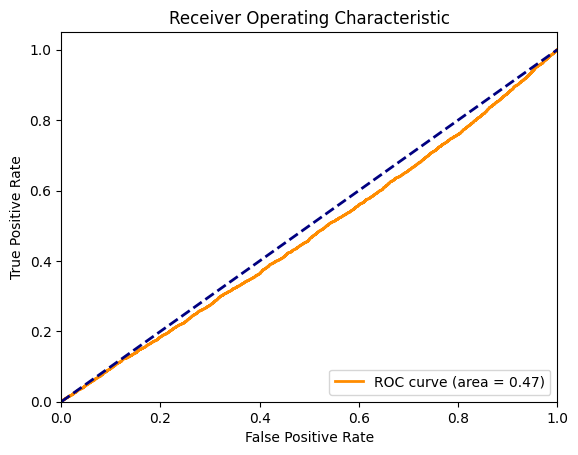

In [29]:
plot_auc(model, train_dataloader)


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1))  # L2 distance
            predictions = (distances < 0.5).cpu().numpy()  # Threshold of 0.5 for similarity
            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dissimilar", "Similar"])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [31]:
from sklearn.manifold import TSNE

def plot_embeddings(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for data1, data2, label in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            embeddings.extend(emb1.cpu().numpy())
            embeddings.extend(emb2.cpu().numpy())
            labels.extend(label.cpu().numpy())
            labels.extend(label.cpu().numpy())  # Add labels for both graphs in the pair

    # Reduce dimensions for visualization (e.g., t-SNE)
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', s=10)
    plt.title("Graph Embeddings (t-SNE)")
    plt.colorbar()
    plt.show()


In [32]:
def print_pair_embeddings(model, dataloader, pair_index=0):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data1, data2, label = next(iter(dataloader))
        emb1 = model(data1.x, data1.edge_index, data1.batch)
        emb2 = model(data2.x, data2.edge_index, data2.batch)
        
        print(f"Embeddings for pair {pair_index}:")
        print("Embedding 1:", emb1)
        print("Embedding 2:", emb2)
        print("Label:", label)


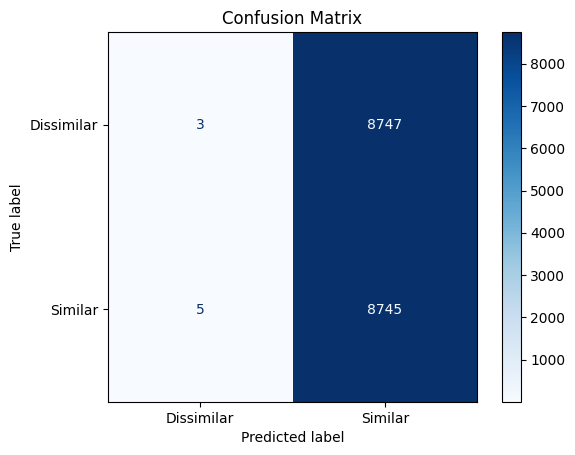

In [33]:
plot_confusion_matrix(model, train_dataloader)


In [34]:
print_pair_embeddings(model, test_dataloader, pair_index=45)

Embeddings for pair 45:
Embedding 1: tensor([[0.5852, 0.6217, 0.5484, 0.6860, 0.6014, 0.6862, 0.7257, 0.6008],
        [0.6443, 0.6797, 0.6636, 0.6343, 0.6725, 0.6450, 0.6498, 0.5036],
        [0.6132, 0.6487, 0.6740, 0.6685, 0.5909, 0.6732, 0.6493, 0.4844],
        [0.6195, 0.6150, 0.6851, 0.6177, 0.6350, 0.6728, 0.6319, 0.6315],
        [0.6254, 0.6194, 0.5703, 0.6612, 0.6096, 0.6605, 0.6599, 0.7027],
        [0.6313, 0.6802, 0.6019, 0.6525, 0.6143, 0.6767, 0.6619, 0.6516],
        [0.6088, 0.6245, 0.6894, 0.6474, 0.7068, 0.6259, 0.6770, 0.4166],
        [0.6764, 0.6180, 0.6192, 0.6375, 0.6471, 0.6783, 0.5914, 0.5775],
        [0.6355, 0.6238, 0.6390, 0.6259, 0.6547, 0.6732, 0.6399, 0.6360],
        [0.5980, 0.6088, 0.5374, 0.6728, 0.5937, 0.7086, 0.7064, 0.6730],
        [0.6060, 0.6262, 0.6702, 0.6781, 0.6838, 0.6263, 0.6723, 0.4584],
        [0.5927, 0.6084, 0.5332, 0.6765, 0.5911, 0.6891, 0.7175, 0.6878],
        [0.5890, 0.6209, 0.6626, 0.6586, 0.5858, 0.6757, 0.6559, 0.6662],
 